# Model Metrics Visualization

This notebook visualizes precision, recall, and F1 scores for labels 0-5 from saved model metrics.

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

sys.path.append(str(Path.cwd().parent.parent))
from utils import DATA_DIR

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 5)

metrics_files = list((DATA_DIR / "metrics").glob("*.json"))
print("Available metrics files:")
for f in metrics_files:
    print(f"  - {f.name}")

Available metrics files:
  - random.json


## Specific model

In [4]:
# Select a metric file to visualize
METRICS_FILE = metrics_files[0]
with open(METRICS_FILE, "r") as f:
    metrics_data = json.load(f)


def extract_per_label_metrics(metrics_dict, dataset="test_metrics"):
    """
    Extract precision, recall, and F1 scores for labels 0-5.

    Args:
        metrics_dict: Dictionary containing model metrics
        dataset: Which dataset to use ('train_metrics', 'cv_metrics', or 'test_metrics')

    Returns:
        DataFrame with precision, recall, and F1 scores for each label
    """
    if metrics_dict[dataset] is None:
        print(f"Warning: {dataset} not available for this model")
        return None

    data = metrics_dict[dataset]

    # Pad with 0.0 if label 5 is missing
    precision = data["precision"] + [0.0] * (6 - len(data["precision"]))
    recall = data["recall"] + [0.0] * (6 - len(data["recall"]))
    f1 = data["f1"] + [0.0] * (6 - len(data["f1"]))
    support = data["support"] + [0] * (6 - len(data["support"]))

    df = pd.DataFrame(
        {
            "Label": range(6),
            "Precision": precision[:6],
            "Recall": recall[:6],
            "F1": f1[:6],
            "Support": support[:6],
        }
    )

    return df


train_df = extract_per_label_metrics(metrics_data, "train_metrics")
cv_df = extract_per_label_metrics(metrics_data, "cv_metrics")
test_df = extract_per_label_metrics(metrics_data, "test_metrics")

print(f"Model: {metrics_data['model']}")
print(f"Parameters: {metrics_data['params']}")

Model: random
Parameters: {}


### Tables

In [6]:
print("=" * 60)
print("TRAIN METRICS")
print("=" * 60)


def _styled_no_index(df):
    """
    Return a Styler that formats columns and hides the row index by CSS.
    This avoids using Styler.hide_index() which may not be available in older pandas.
    """
    fmt = {"Precision": "{:.4f}", "Recall": "{:.4f}", "F1": "{:.4f}", "Support": "{:d}"}
    # Hide the index column via CSS selectors for row headings / blank header
    return df.style.format(fmt).set_table_styles(
        [{"selector": "th.row_heading, th.blank", "props": [("display", "none")]}]
    )


if train_df is not None:
    display(_styled_no_index(train_df))
    if metrics_data.get("train_metrics") is not None:
        print(f"Accuracy: {metrics_data['train_metrics']['accuracy']:.4f}")
        print(f"MSE: {metrics_data['train_metrics']['mse']:.4f}")

print("\n" + "=" * 60)
print("CROSS-VALIDATION METRICS")
print("=" * 60)
if cv_df is not None:
    display(_styled_no_index(cv_df))
    if metrics_data.get("cv_metrics") is not None:
        print(f"Accuracy: {metrics_data['cv_metrics']['accuracy']:.4f}")
        print(f"MSE: {metrics_data['cv_metrics']['mse']:.4f}")

print("\n" + "=" * 60)
print("TEST METRICS")
print("=" * 60)
if test_df is not None:
    display(_styled_no_index(test_df))
    if metrics_data.get("test_metrics") is not None:
        print(f"Accuracy: {metrics_data['test_metrics']['accuracy']:.4f}")
        print(f"MSE: {metrics_data['test_metrics']['mse']:.4f}")

TRAIN METRICS


,Label,Precision,Recall,F1,Support
0,0,0.3305,0.3391,0.3348,115
1,1,0.1803,0.1618,0.1705,68
2,2,0.1778,0.2025,0.1893,79
3,3,0.1803,0.1692,0.1746,65
4,4,0.2419,0.2308,0.2362,65
5,5,0.0000,0.0000,0.0000,0


Accuracy: 0.2347
MSE: 5.3495

CROSS-VALIDATION METRICS


,Label,Precision,Recall,F1,Support
0,0,0.3383,0.3093,0.3151,115
1,1,0.1235,0.2214,0.1523,68
2,2,0.1443,0.1164,0.1261,79
3,3,0.1667,0.1623,0.1641,65
4,4,0.1495,0.1555,0.1500,65
5,5,0.0000,0.0000,0.0000,0


Accuracy: 0.1965
MSE: 5.3690

TEST METRICS


,Label,Precision,Recall,F1,Support
0,0,0.3506,0.3506,0.3506,77
1,1,0.1316,0.1111,0.1205,45
2,2,0.1746,0.2115,0.1913,52
3,3,0.2195,0.2045,0.2118,44
4,4,0.2093,0.2045,0.2069,44
5,5,0.0000,0.0000,0.0000,0


Accuracy: 0.2328
MSE: 5.4389


### Confusion Matrix

TRAIN SET CONFUSION MATRIX


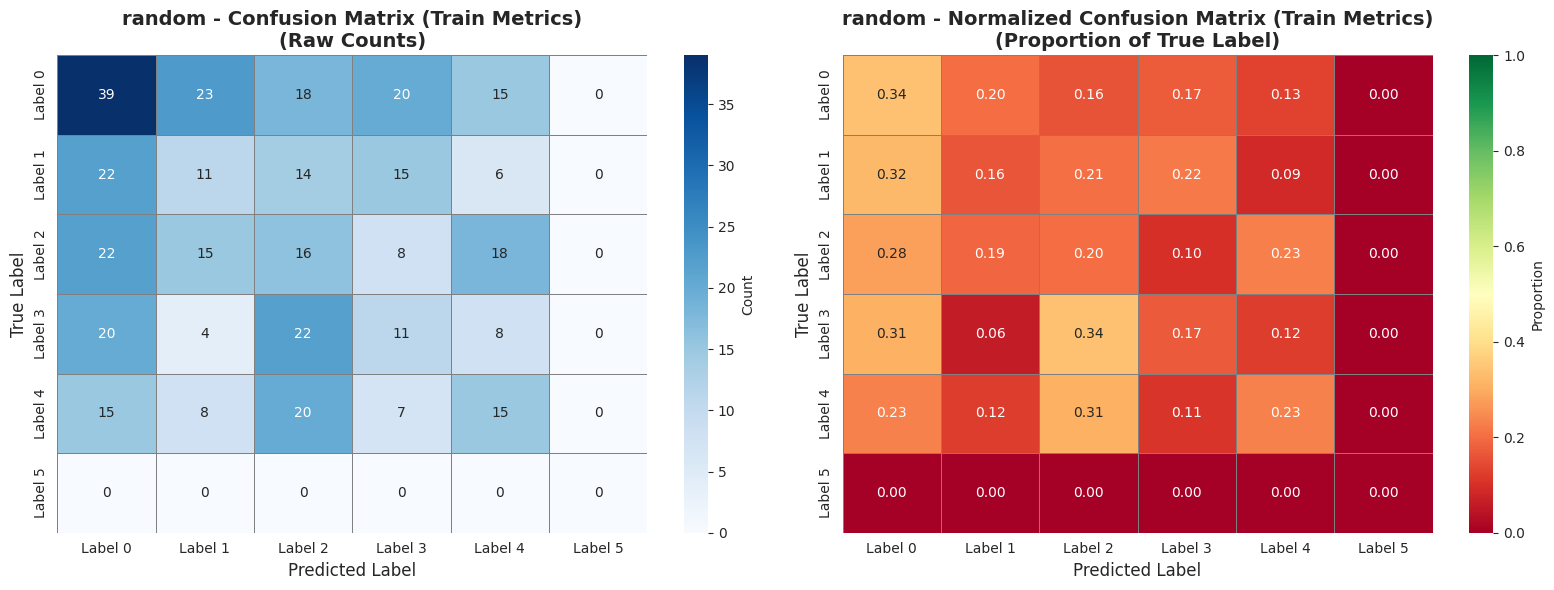


Confusion Matrix Statistics:
  Total predictions: 392
  Correct predictions (diagonal): 92
  Incorrect predictions (off-diagonal): 300
  Accuracy: 0.2347

Per-label statistics:
  Label 0: 39/115 correct (33.91%)
  Label 1: 11/68 correct (16.18%)
  Label 2: 16/79 correct (20.25%)
  Label 3: 11/65 correct (16.92%)
  Label 4: 15/65 correct (23.08%)
  Label 5: No samples

CROSS-VALIDATION CONFUSION MATRIX


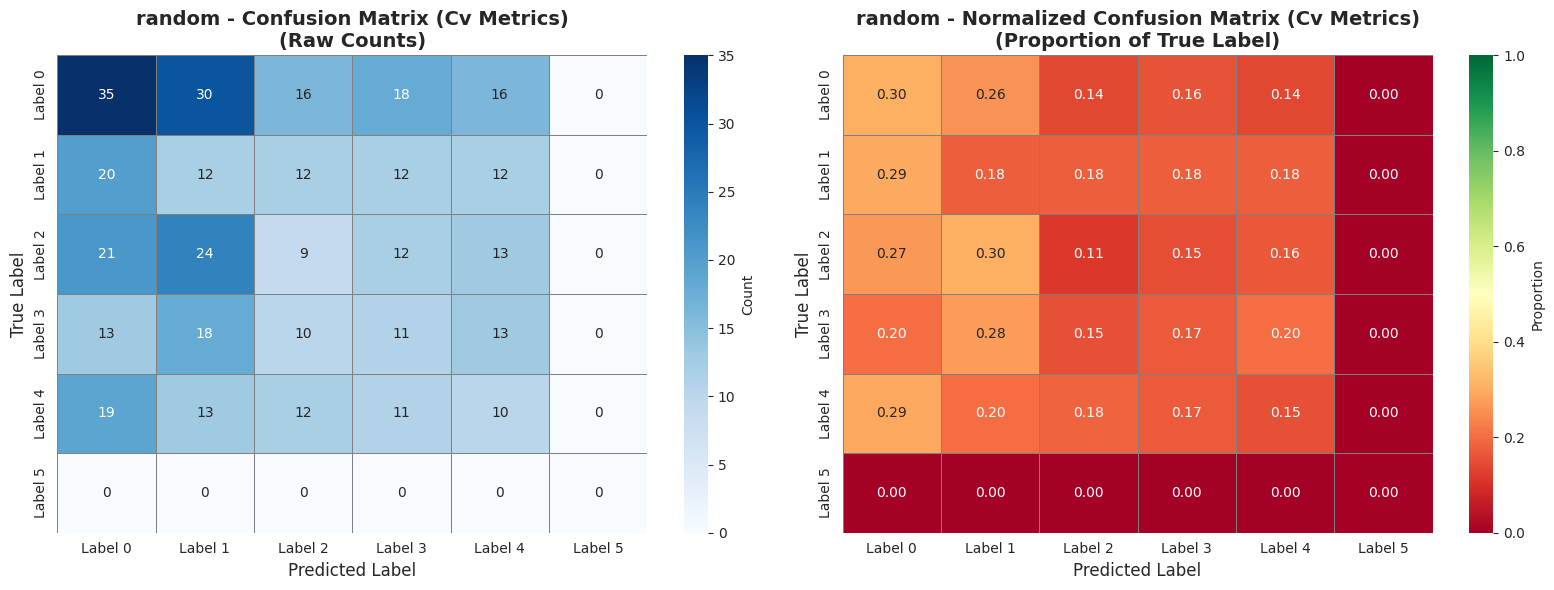


Confusion Matrix Statistics:
  Total predictions: 392
  Correct predictions (diagonal): 77
  Incorrect predictions (off-diagonal): 315
  Accuracy: 0.1964

Per-label statistics:
  Label 0: 35/115 correct (30.43%)
  Label 1: 12/68 correct (17.65%)
  Label 2: 9/79 correct (11.39%)
  Label 3: 11/65 correct (16.92%)
  Label 4: 10/65 correct (15.38%)
  Label 5: No samples

TEST SET CONFUSION MATRIX


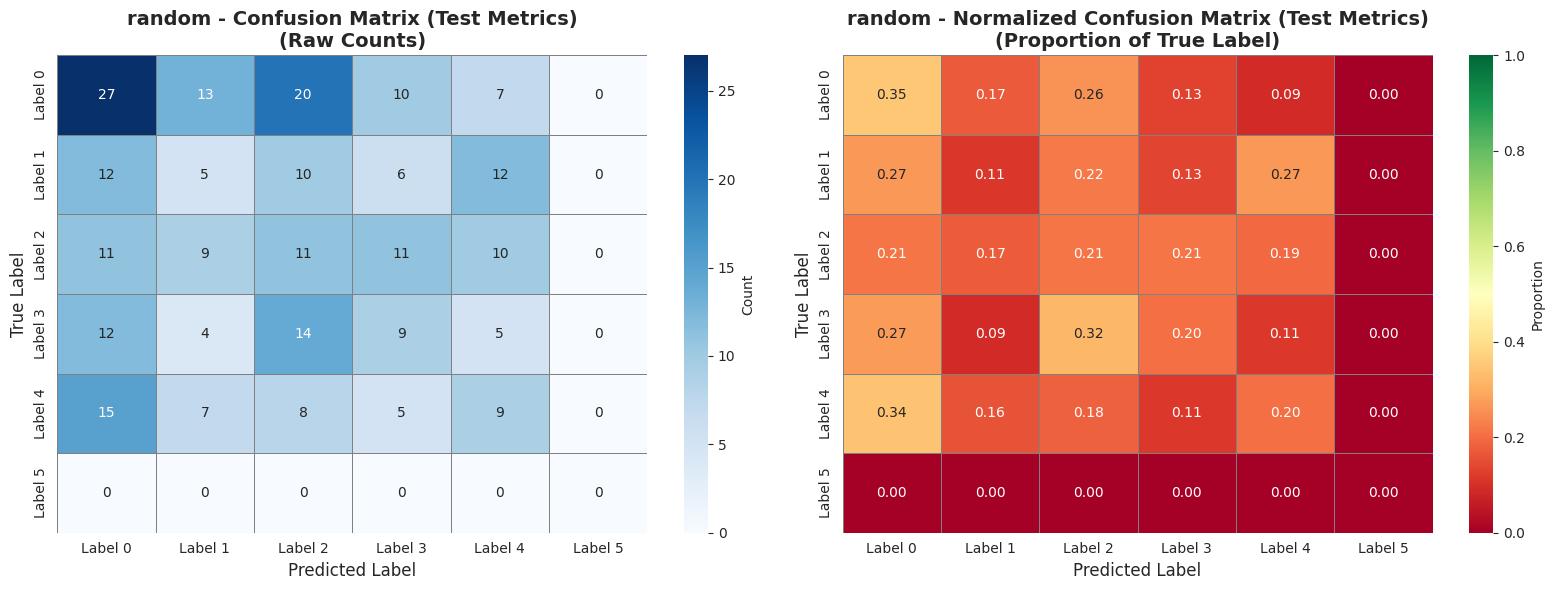


Confusion Matrix Statistics:
  Total predictions: 262
  Correct predictions (diagonal): 61
  Incorrect predictions (off-diagonal): 201
  Accuracy: 0.2328

Per-label statistics:
  Label 0: 27/77 correct (35.06%)
  Label 1: 5/45 correct (11.11%)
  Label 2: 11/52 correct (21.15%)
  Label 3: 9/44 correct (20.45%)
  Label 4: 9/44 correct (20.45%)
  Label 5: No samples


In [7]:
def plot_confusion_matrix(metrics_dict, dataset="test_metrics"):
    """
    Plot confusion matrix showing hits (diagonal) and misses (off-diagonal).

    Args:
        metrics_dict: Dictionary containing model metrics
        dataset: Which dataset to use ('train_metrics', 'cv_metrics', or 'test_metrics')
    """
    if metrics_dict[dataset] is None:
        print(f"Warning: {dataset} not available for this model")
        return

    data = metrics_dict[dataset]

    cm = np.array(data["confusion_matrix"])
    # Pad to 6x6 if needed (for label 5)
    if cm.shape[0] < 6:
        padded_cm = np.zeros((6, 6), dtype=int)
        padded_cm[: cm.shape[0], : cm.shape[1]] = cm
        cm = padded_cm

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax1,
        linewidths=0.5,
        linecolor="gray",
        cbar_kws={"label": "Count"},
    )
    ax1.set_title(
        f"{metrics_dict['model']} - Confusion Matrix ({dataset.replace('_', ' ').title()})\n(Raw Counts)",
        fontsize=14,
        fontweight="bold",
    )
    ax1.set_xlabel("Predicted Label", fontsize=12)
    ax1.set_ylabel("True Label", fontsize=12)
    ax1.set_xticklabels([f"Label {i}" for i in range(6)])
    ax1.set_yticklabels([f"Label {i}" for i in range(6)])

    # Plot 2: Normalized confusion matrix (by true label)
    cm_normalized = cm.astype("float")
    row_sums = cm.sum(axis=1, keepdims=True)
    # Avoid division by zero
    row_sums[row_sums == 0] = 1
    cm_normalized = cm_normalized / row_sums

    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2f",
        cmap="RdYlGn",
        ax=ax2,
        linewidths=0.5,
        linecolor="gray",
        cbar_kws={"label": "Proportion"},
        vmin=0,
        vmax=1,
    )
    ax2.set_title(
        f"{metrics_dict['model']} - Normalized Confusion Matrix ({dataset.replace('_', ' ').title()})\n(Proportion of True Label)",
        fontsize=14,
        fontweight="bold",
    )
    ax2.set_xlabel("Predicted Label", fontsize=12)
    ax2.set_ylabel("True Label", fontsize=12)
    ax2.set_xticklabels([f"Label {i}" for i in range(6)])
    ax2.set_yticklabels([f"Label {i}" for i in range(6)])

    plt.tight_layout()
    plt.show()

    total = cm.sum()
    correct = np.trace(cm)
    accuracy = correct / total if total > 0 else 0

    print("\nConfusion Matrix Statistics:")
    print(f"  Total predictions: {total}")
    print(f"  Correct predictions (diagonal): {correct}")
    print(f"  Incorrect predictions (off-diagonal): {total - correct}")
    print(f"  Accuracy: {accuracy:.4f}")
    print("\nPer-label statistics:")
    for i in range(6):
        true_count = cm[i, :].sum()
        correct_count = cm[i, i]
        if true_count > 0:
            per_label_acc = correct_count / true_count
            print(
                f"  Label {i}: {correct_count}/{true_count} correct ({per_label_acc:.2%})"
            )
        else:
            print(f"  Label {i}: No samples")


print("=" * 80)
print("TRAIN SET CONFUSION MATRIX")
print("=" * 80)
plot_confusion_matrix(metrics_data, "train_metrics")

print("\n" + "=" * 80)
print("CROSS-VALIDATION CONFUSION MATRIX")
print("=" * 80)
plot_confusion_matrix(metrics_data, "cv_metrics")

print("\n" + "=" * 80)
print("TEST SET CONFUSION MATRIX")
print("=" * 80)
plot_confusion_matrix(metrics_data, "test_metrics")

## All models

Comparing all available models...



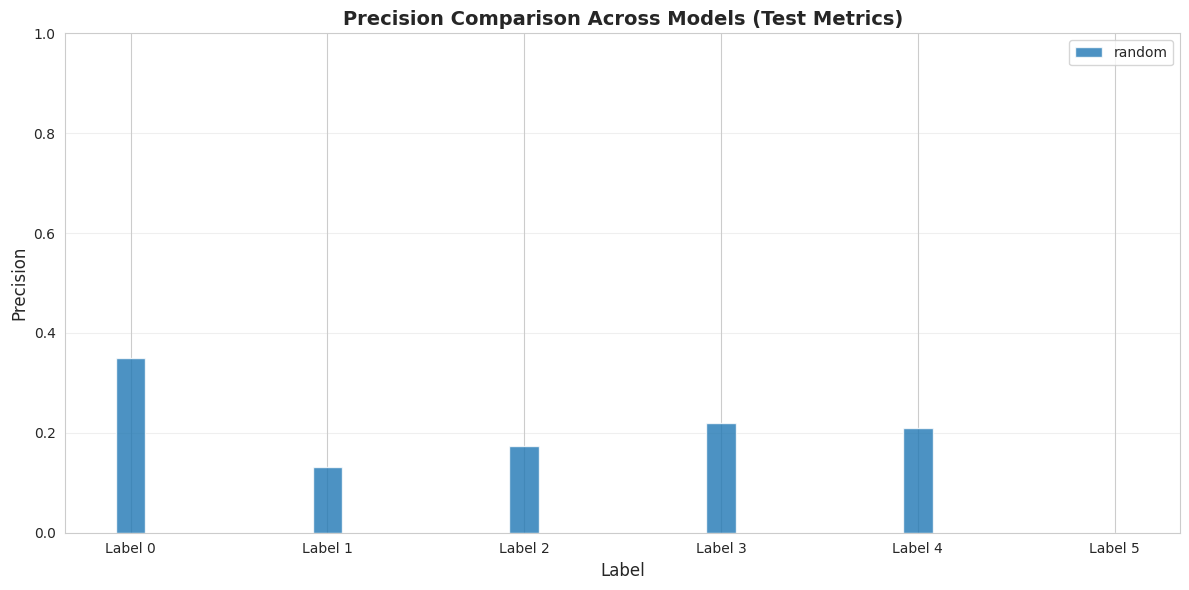

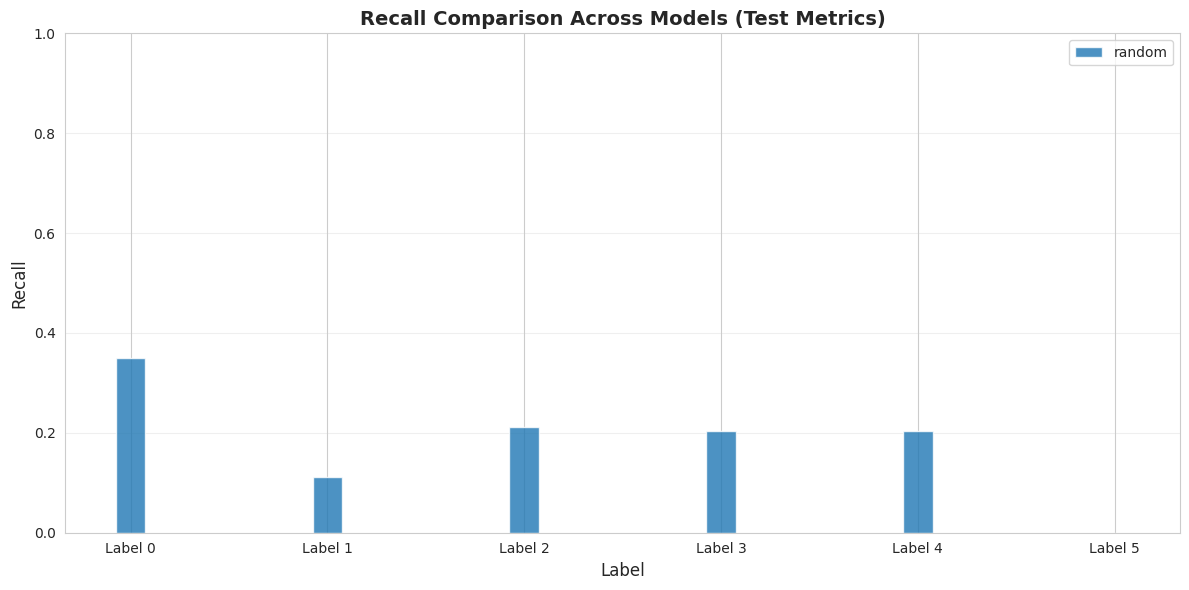

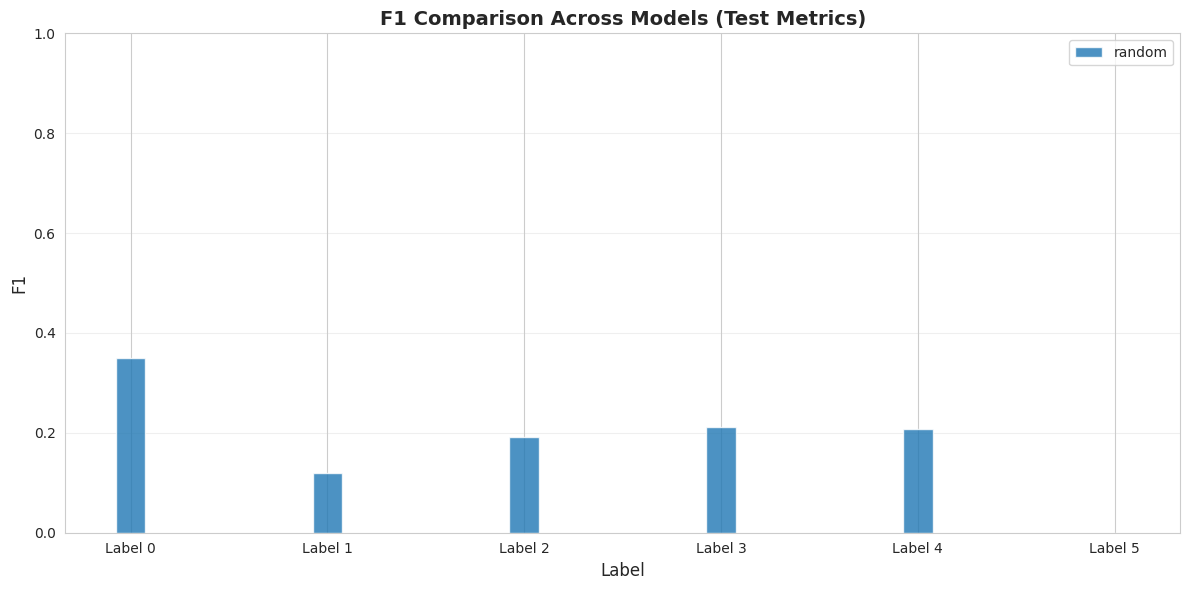

In [8]:
def compare_models(metrics_files, dataset="test_metrics"):
    """
    Compare metrics across multiple models.
    """
    models_data = []

    for file in metrics_files:
        with open(file, "r") as f:
            data = json.load(f)
            if data.get(dataset) is not None:
                models_data.append({"model": data["model"], "metrics": data[dataset]})

    if not models_data:
        print(f"No models with {dataset} available")
        return

    for metric_name in ["Precision", "Recall", "F1"]:
        fig, ax = plt.subplots(figsize=(12, 6))

        for i, model_data in enumerate(models_data):
            metric_key = metric_name.lower()
            values = model_data["metrics"][metric_key]
            # Pad to 6 labels
            values = values + [0.0] * (6 - len(values))

            x = np.arange(6) + i * 0.15
            ax.bar(x, values[:6], width=0.15, label=model_data["model"], alpha=0.8)

        ax.set_xlabel("Label", fontsize=12)
        ax.set_ylabel(metric_name, fontsize=12)
        ax.set_title(
            f"{metric_name} Comparison Across Models ({dataset.replace('_', ' ').title()})",
            fontsize=14,
            fontweight="bold",
        )
        ax.set_xticks(np.arange(6) + 0.15 * (len(models_data) - 1) / 2)
        ax.set_xticklabels([f"Label {i}" for i in range(6)])
        ax.legend(fontsize=10)
        ax.set_ylim(0, 1.0)
        ax.grid(axis="y", alpha=0.3)

        plt.tight_layout()
        plt.show()


if len(metrics_files) > 0:
    print("Comparing all available models...\n")
    compare_models(metrics_files, "test_metrics")

In [10]:
all_metrics = []
for file in metrics_files:
    with open(file, "r") as f:
        data = json.load(f)
        all_metrics.append(
            {
                "Model": data["model"],
                "Train RMSE": np.sqrt(data.get("train_metrics", {}).get("mse", np.nan))
                if data.get("train_metrics", {}).get("mse") is not None
                else np.nan,
                "CV RMSE": np.sqrt(data.get("cv_metrics", {}).get("mse", np.nan))
                if data.get("cv_metrics", {}).get("mse") is not None
                else np.nan,
                "Test RMSE": np.sqrt(data.get("test_metrics", {}).get("mse", np.nan))
                if data.get("test_metrics", {}).get("mse") is not None
                else np.nan,
                "Train Acc": data.get("train_metrics", {}).get("accuracy", None),
                "CV Acc": data.get("cv_metrics", {}).get("accuracy", None),
                "Test Acc": data.get("test_metrics", {}).get("accuracy", None),
            }
        )

metrics_df = pd.DataFrame(all_metrics)

display(
    metrics_df.style.format(
        {
            "Train RMSE": "{:.4f}",
            "CV RMSE": "{:.4f}",
            "Test RMSE": "{:.4f}",
            "Train Acc": "{:.4f}",
            "CV Acc": "{:.4f}",
            "Test Acc": "{:.4f}",
        }
    ).set_caption("Model Metrics Comparison")
)

,Model,Train RMSE,CV RMSE,Test RMSE,Train Acc,CV Acc,Test Acc
0,random,2.3129,2.3171,2.3322,0.2347,0.1965,0.2328


## Training Curves Visualization

This section visualizes training and validation loss curves for fine-tuning trials.

In [ ]:
from models.encoder.common import TRAINING_HISTORY_DIR


def plot_training_curve(trial_data):
    """
    Plot training and validation loss curves for a specific trial and fold.

    Args:
        trial_data: Dictionary containing training history data
        trial_num: Trial number for the title
        fold_num: Fold number (optional, for title)
    """
    train_loss_history = trial_data["train_loss_history"]
    val_loss_history = trial_data["val_loss_history"]
    batches_per_epoch = trial_data["batches_per_epoch"]
    current_epoch = trial_data["current_epoch"]

    train_batches, train_losses = (
        zip(*train_loss_history) if train_loss_history else ([], [])
    )
    val_batches, val_losses = zip(*val_loss_history) if val_loss_history else ([], [])

    plt.figure(figsize=(12, 6))

    if train_batches:
        plt.plot(
            train_batches,
            train_losses,
            "b-",
            alpha=0.3,
            linewidth=0.5,
            label="Train Loss (batch)",
        )
    if val_batches:
        plt.plot(
            val_batches,
            val_losses,
            "r-o",
            linewidth=2,
            markersize=6,
            label="Val Loss (batch)",
        )

    plt.xlabel("Batch Number", fontsize=12)
    plt.ylabel("Loss", fontsize=12)

    title = "Training and Validation Loss"
    plt.title(title, fontsize=14, fontweight="bold")

    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    # Add vertical lines at epoch boundaries
    for e in range(1, current_epoch + 1):
        plt.axvline(
            x=e * batches_per_epoch - 1, color="gray", linestyle="--", alpha=0.2
        )

    plt.tight_layout()
    plt.show()

    if val_losses:
        print("\\nTraining Summary:")
        print(f"  Completed Epochs: {current_epoch}")
        print(f"  Final Train Loss: {train_losses[-1]:.4f}")
        print(f"  Final Val Loss: {val_losses[-1]:.4f}")
        print(
            f"  Best Val Loss: {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses)) + 1})"
        )


def plot_all_folds_for_trial(trials, trial_num):
    """
    Plot training curves for all folds of a specific trial in a grid.
    """
    if trial_num not in trials:
        print(f"Trial {trial_num} not found")
        return

    folds = sorted(trials[trial_num].keys())
    n_folds = len(folds)

    if n_folds == 0:
        print(f"No folds found for trial {trial_num}")
        return

    # Create subplot grid
    n_cols = min(3, n_folds)
    n_rows = (n_folds + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    if n_folds == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_rows > 1 else axes

    for idx, fold_num in enumerate(folds):
        ax = axes[idx] if n_folds > 1 else axes[0]
        trial_data = trials[trial_num][fold_num]

        train_loss_history = trial_data["train_loss_history"]
        val_loss_history = trial_data["val_loss_history"]
        batches_per_epoch = trial_data["batches_per_epoch"]
        current_epoch = trial_data["current_epoch"]

        train_batches, train_losses = (
            zip(*train_loss_history) if train_loss_history else ([], [])
        )
        val_batches, val_losses = (
            zip(*val_loss_history) if val_loss_history else ([], [])
        )

        if train_batches:
            ax.plot(
                train_batches,
                train_losses,
                "b-",
                alpha=0.3,
                linewidth=0.5,
                label="Train Loss",
            )
        if val_batches:
            ax.plot(
                val_batches,
                val_losses,
                "r-o",
                linewidth=2,
                markersize=4,
                label="Val Loss",
            )

        # Epoch boundaries
        for e in range(1, current_epoch + 1):
            ax.axvline(
                x=e * batches_per_epoch - 1, color="gray", linestyle="--", alpha=0.2
            )

        ax.set_xlabel("Batch Number")
        ax.set_ylabel("Loss")
        ax.set_title(f"Fold {fold_num}", fontweight="bold")
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for idx in range(n_folds, len(axes)):
        axes[idx].axis("off")

    fig.suptitle(
        f"Trial {trial_num} - All Folds", fontsize=16, fontweight="bold", y=1.00
    )
    plt.tight_layout()
    plt.show()

### Cross-validation

In [ ]:
history_files = sorted(list(TRAINING_HISTORY_DIR.glob("trial_*_fold_*.json")))
print(f"Found {len(history_files)} training history files")

trials = {}
for file in history_files:
    with open(file, "r") as f:
        data = json.load(f)
        trial_num = data["trial_number"]
        fold_num = data["fold_num"]

        if trial_num not in trials:
            trials[trial_num] = {}
        trials[trial_num][fold_num] = data

print(f"Trials: {sorted(trials.keys())}")

In [ ]:
TRIAL_TO_PRINT = 0

chosen_trial = sorted(trials.keys())[TRIAL_TO_PRINT]
print(f"Plotting all folds for Trial {chosen_trial}")
plot_all_folds_for_trial(trials, chosen_trial)